In [23]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [24]:
train_image_path = 'C:/Users/shiva/OneDrive/Documents/Need/Intel images/seg_train/seg_train/'
test_image_path = 'C:/Users/shiva/OneDrive/Documents/Need/Intel images/seg_test/seg_test/'
pred_image_path = 'C:/Users/shiva/OneDrive/Documents/Need/Intel images/seg_pred/'

In [25]:
train_dt = tf.keras.preprocessing.image_dataset_from_directory(train_image_path,
                                                                image_size = (150, 150), batch_size = 32)

test_dt = tf.keras.preprocessing.image_dataset_from_directory(test_image_path,
                                                                image_size = (150, 150), batch_size = 32)

pred_dt = tf.keras.preprocessing.image_dataset_from_directory(pred_image_path,
                                                       image_size = (150,150), batch_size = 32)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 7301 files belonging to 1 classes.


In [26]:
class_names = train_dt.class_names
print('Names of the class: ', end="")
print(class_names)
print('Trainin dataset shape: ', [i[0].numpy().shape for i in train_dt.take(1)])

Names of the class: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Trainin dataset shape:  [(32, 150, 150, 3)]


In [27]:
print('Number of batches for training dataset: ', len(train_dt))
print('Number of batches for testing dataset: ', len(test_dt))
print('Number of batches for prediction dataset: ', len(pred_dt))

Number of batches for training dataset:  439
Number of batches for testing dataset:  94
Number of batches for prediction dataset:  229


Sample of training dataset
(32, 150, 150, 3)


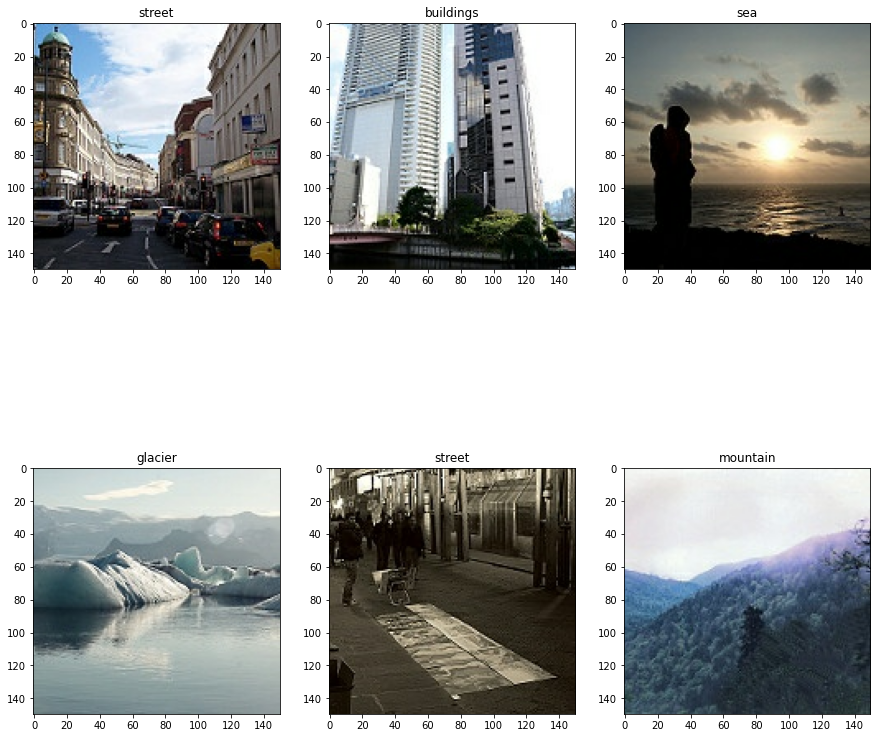

In [28]:
plt.figure(figsize = (15,15))
for img, lbl in train_dt.take(1):
    print('Sample of training dataset')
    print(img.shape)
    for i in range(6):
        plt.subplot(2,3, i+1)
        plt.imshow(img.numpy()[i].astype('uint8'))
        plt.title(class_names[lbl[i]])

In [29]:
train_dt.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_dt.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
pred_dt.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [30]:
resizing_and_scaling = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(150, 150),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [31]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
#     layers.experimental.preprocessing.RandomZoom(0.3),
    layers.experimental.preprocessing.RandomHeight(0.3),
    layers.experimental.preprocessing.RandomWidth(0.3),
#     layers.experimental.preprocessing.RandomCrop(150,150),
#     layers.experimental.preprocessing.RandomContrast(0.2),
#     layers.experimental.preprocessing.RandomRotation(0.2)
])

In [32]:
train_dt = train_dt.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
input_shape = (32,150,150, 3)
output_classes = 6
model = models.Sequential([
    resizing_and_scaling,
    layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape, padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(output_classes, activation = 'softmax')
])

model.build(input_shape = input_shape)

In [34]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (32, 150, 150, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (32, 150, 150, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 75, 75, 32)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (32, 75, 75, 64)          18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 37, 37, 64)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 35, 35, 64)         

In [35]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [36]:
logs = model.fit(
    train_dt,
    batch_size = 32,
    validation_data = test_dt,
    verbose = 1,
    epochs = 5
)

Epoch 1/5
439/439 [==============================] - 322s 730ms/step - loss: 1.1458 - accuracy: 0.5477 - val_loss: 1.6237 - val_accuracy: 0.3827
Epoch 2/5
439/439 [==============================] - 298s 678ms/step - loss: 0.8511 - accuracy: 0.6780 - val_loss: 1.8102 - val_accuracy: 0.4003
Epoch 3/5
439/439 [==============================] - 296s 673ms/step - loss: 0.7236 - accuracy: 0.7313 - val_loss: 1.4142 - val_accuracy: 0.5007
Epoch 4/5
439/439 [==============================] - 292s 664ms/step - loss: 0.6350 - accuracy: 0.7687 - val_loss: 1.3962 - val_accuracy: 0.4843
Epoch 5/5
439/439 [==============================] - 697s 2s/step - loss: 0.5967 - accuracy: 0.7849 - val_loss: 1.3963 - val_accuracy: 0.5083


In [37]:
y_test1 = [s[1] for s in test_dt.take(3000)]
y_pred = model.predict(test_dt)
y_pred = np.argmax(y_pred,axis=1)

94/94 [==============================] - 9s 89ms/step


In [38]:
y_test = []
for i in y_test1 :
    for j in i :
        y_test.append(j)

In [39]:
print(classification_report(y_test,y_pred,target_names = class_names))

              precision    recall  f1-score   support

   buildings       0.16      0.11      0.13       437
      forest       0.17      0.18      0.17       474
     glacier       0.20      0.38      0.26       553
    mountain       0.14      0.01      0.01       525
         sea       0.19      0.17      0.18       510
      street       0.18      0.22      0.20       501

    accuracy                           0.18      3000
   macro avg       0.17      0.18      0.16      3000
weighted avg       0.17      0.18      0.16      3000



1/1 [==============================] - 0s 181ms/step


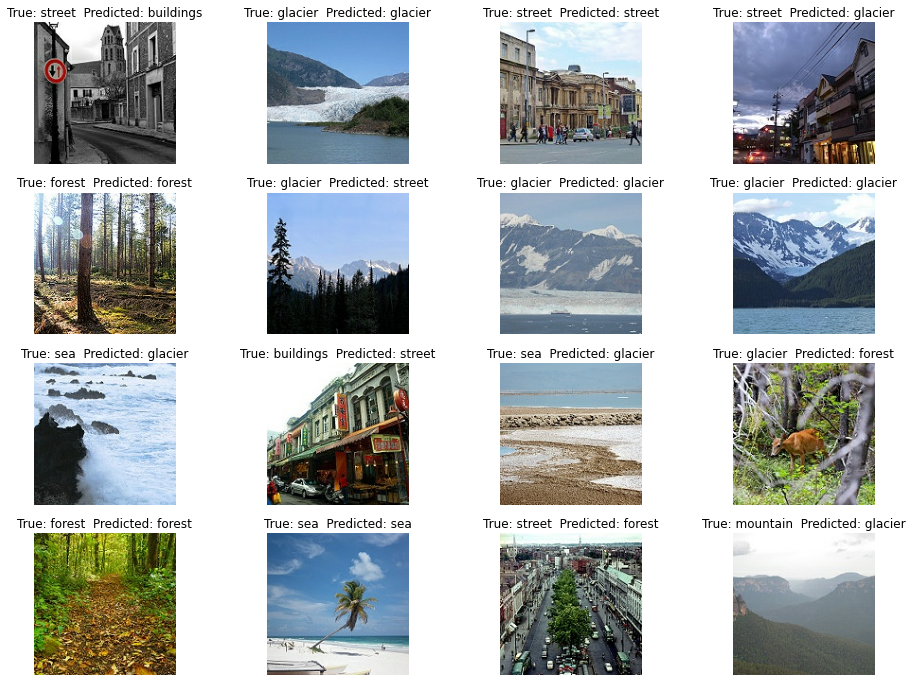

In [40]:
plt.figure(figsize=(16, 12))

for images_batch, labels_batch in test_dt.take(1):
    predictions = model.predict(images_batch)
    predicted_classes = np.argmax(predictions, axis=1)

    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'True: {class_names[labels[i]]}  Predicted: {class_names[predicted_classes[i]]}')
        plt.axis('off')

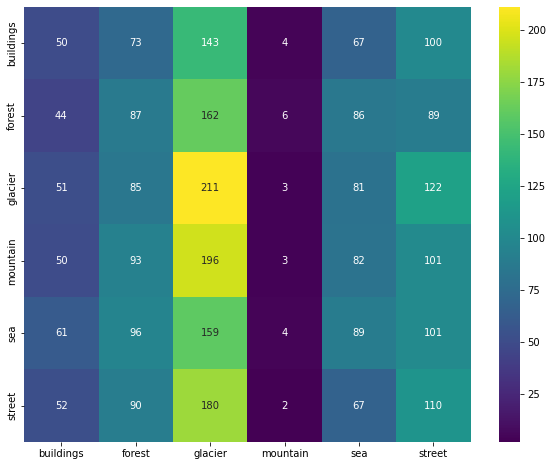

In [41]:

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.3g',xticklabels=class_names,yticklabels=class_names,cmap='viridis')
plt.show()